In [20]:
import py_wgpu_fdm as fdm
import numpy as np
import math

Simulation settings; these are immutable and should be kept consistent across all simluations:
+ `node_count` defines the amount of nodes
+ `chunk_size` defines the size out the output buffer that are kept in GPU memory before being pushed to the CPU
+ `oversampling_factor` defines the how many steps are calculated per saved output. This is done to increase numerical stability.

Thus the total number of calculations is `node_count * chunk_size * oversampling_factor`


In [21]:
node_count = 2048
chunk_size = 1024
oversampling_factor = 1024

Then we initialize memory layouts of the nodes that are passed to rust.

In [22]:
zeroes = lambda: [ 0.0 for _ in range(4)]
# Initialize nodes as zeroed out
nodes = [ [ zeroes(), zeroes() ] for _ in range(node_count) ]

Next we define all necessary parameters for the respective simulation.

In [23]:
# Simluation parameters
L = 1.945                              # Length (m)
dx = L / (node_count - 1)            # Spatial delta
T = 1.0                              # Total duration (s)
dt = 1/(44100 * oversampling_factor) # Time delta (s)

In [12]:

# Material parameters
d = 1.3e-3         # Wire diameter (m)
D = 3.5e-3         # String diameter (m)
n = L/d            # Windings (1)
E = 130e9          # Young's Modulus copper (Pa)
G = 46e9           # Shear Modulus copper (Pa)
rho_winding = 8960 # Density copper (kg/m^3)
nu = 0.34          # Poisson's ratio (1)
F_T = 120          # External tensioning force (N)

# Effective material properties (round wire)
GA = (E * d**4 * L)/(8 * n * D**3)
EI = (E * d**4 * L)/(32 * (2 + nu) * n * D)
EA = (G * d**4 * L)/(8 * n * D**3)
m_winding = (rho_winding * np.pi**2 * d**2 * n * D)/(4 * L) # mass / unit length


# Material properties core
rho_core = 7850
d_core = D - d      # diameter core (m)
A = np.pi * d**2 / 4
m_core = rho_core * A   # mass / unit length

# Combined masses per unit length
m = m_core + m_winding


I_core = (np.pi / 64) * d_core**4
I_winding = (np.pi / 64) * (D**4 - d_core**4)

rhoI = rho_winding * I_winding + rho_core * I_core

print(EI, GA, m_winding, m, rhoI)

print(0.0035956, 12445, 0.0580199, )

0.0018417311507936505 1407.2329446064136 0.10059100805590274 0.11101049279061498
0.0035956 12445 0.0580199


In [24]:
A = 1.31e-6
rho = 44290
F_T = 1328
E = 2.02e11
I = 1.78e-14
G = 1.00e10
kappa = 0.95

GA = G * kappa * A
EI = E * I
rhoI = rho * I
m = rho * A

as well as the intial conditions

In [25]:
gaussian_disp = lambda n, i, max_val: float(0.0 if i == 0 or i == n - 1 else max_val * \
    np.exp(-((i - (n - 1) / 2) ** 2) / (2 * (n * 0.25) ** 2)))

max_displacement = 0.005

ws = [ gaussian_disp(node_count, i, max_displacement) for i in range(node_count) ]
phis = [float(f) for f in np.gradient(ws) ]
nodes = list()

for i in range(node_count):
    nodes.append([[ ws[i], phis[i], ws[i], phis[i] ], [0.0, 0.0, 0.0, 0.0 ]] )

We can now create a new Simulation instance and set up its parameters, matching them to the appropriate generic paramter names (j, k, etc.) defined in the shader.
This creates a simulation instance that lives in memory allocated by rust and handles all GPU interaction.

In [26]:
print(GA, EI, rhoI, m)

v = max((F_T/rho)**0.5, (GA/rho)**0.5, (EI / m)**0.25)

print(dt, dx/v)

12445.0 0.0035956 7.883620000000001e-10 0.0580199
2.2144274376417234e-08 0.0017924916970828595


In [27]:
# Initialize simulation
sim = fdm.Simulation(nodes, chunk_size, oversampling_factor)

# Set parameters
sim.set_dx(dx)
sim.set_dt(dt)
sim.set_j(GA)
sim.set_k(EI)
sim.set_m(m)
sim.set_l(rhoI)
sim.set_n(F_T)
sim.set_o(0.9999)


Given a chunk size and an effective time delta (including the oversampling factor), we can calculate the amount of required compute invocations:

In [28]:
invocations = math.ceil(44100 * T / chunk_size) # minimum amount of invocations required

print(f'Calling compute() {invocations} times.')

Calling compute() 44 times.


Finally we run the simulation `invocations`-times and append generated output to our list. 
The output on the rust side includes both w and phi, so we should also extract the field we're interested in.

In [29]:
result = list()

for i in range(invocations):
    result += sim.compute()
    print(f'Finished computation {i+1}...')

displacements = [ r[0] for r in result ]

Finished computation 1...
Finished computation 2...
Finished computation 3...
Finished computation 4...
Finished computation 5...
Finished computation 6...
Finished computation 7...
Finished computation 8...
Finished computation 9...
Finished computation 10...
Finished computation 11...
Finished computation 12...
Finished computation 13...
Finished computation 14...
Finished computation 15...
Finished computation 16...
Finished computation 17...
Finished computation 18...
Finished computation 19...
Finished computation 20...
Finished computation 21...
Finished computation 22...
Finished computation 23...
Finished computation 24...
Finished computation 25...
Finished computation 26...
Finished computation 27...
Finished computation 28...
Finished computation 29...
Finished computation 30...
Finished computation 31...
Finished computation 32...
Finished computation 33...
Finished computation 34...
Finished computation 35...
Finished computation 36...
Finished computation 37...
Finished c

In [30]:
displacements[:50]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

We can plot the output, though this is a somewhat meaningless graph for high frequences or longer durations.

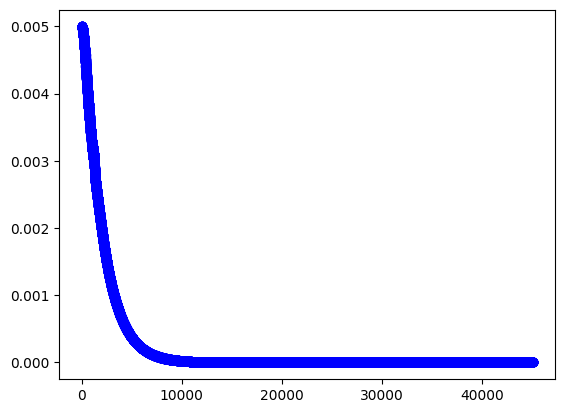

In [19]:
import matplotlib.pyplot as plt

plt.plot(displacements, marker='o', linestyle='-', color='b')
plt.show()

The FFT of the signal is more more interesting:

Top 5 frequency components (excluding DC):
Frequency: 56.00 Hz, Magnitude: 81.75
Frequency: 55.00 Hz, Magnitude: 51.09
Frequency: 57.00 Hz, Magnitude: 22.92
Frequency: 54.00 Hz, Magnitude: 19.30
Frequency: 58.00 Hz, Magnitude: 13.40


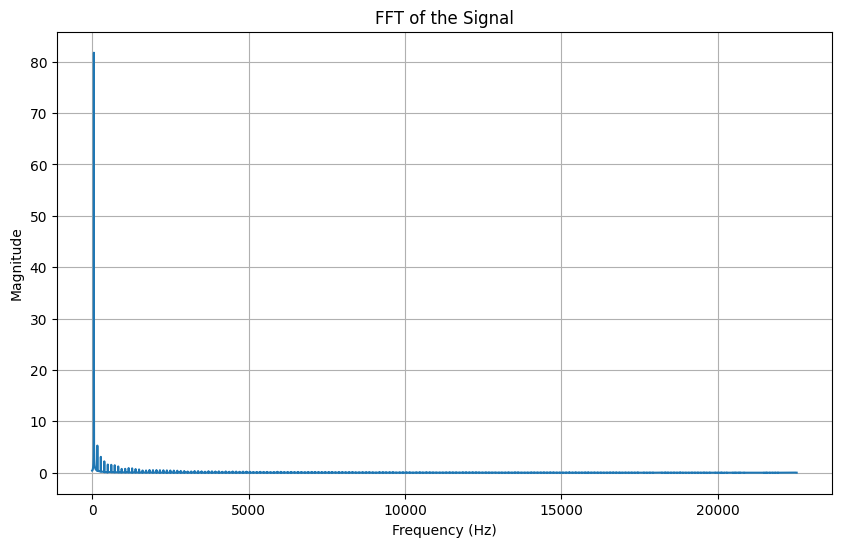

In [11]:
sr = invocations * chunk_size / T
# Perform FFT
fft_result = np.fft.fft(displacements)
fft_magnitude = np.abs(fft_result)[:len(fft_result)//2]  # Take only the positive frequencies
freqs = np.fft.fftfreq(len(result), 1 / sr)[:len(fft_result)//2]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(freqs, fft_magnitude)
plt.title('FFT of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)

nonzero_indices = np.where(freqs > 0)
top_indices = np.argsort(fft_magnitude[nonzero_indices])[::-1][:5]
top_freqs = freqs[nonzero_indices][top_indices]
top_magnitudes = fft_magnitude[nonzero_indices][top_indices]

print("Top 5 frequency components (excluding DC):")
for f, m in zip(top_freqs, top_magnitudes):
    print(f"Frequency: {f:.2f} Hz, Magnitude: {m:.2f}")


We can run the same simulation again, setting `GA` to `0`. This effectively removes the terms from the Timoshenko PDEs, reducing the system to the 1D wave equation.
We run the simulation again, saving the output and comparing it to the FFT from above.

In [12]:
# Initialize simulation
sim = fdm.Simulation(nodes, chunk_size, oversampling_factor)

# Set parameters
sim.set_dx(dx)
sim.set_dt(dt)
sim.set_j(0)
sim.set_k(EI)
sim.set_m(m)
sim.set_l(rhoI)
sim.set_n(F_T)

wave_eq_result = list()

for i in range(invocations):
    wave_eq_result += sim.compute()
    print(f'Finished computation {i+1}...')

wave_eq_displacements = [ r[0] for r in wave_eq_result ]

Finished computation 1...
Finished computation 2...
Finished computation 3...
Finished computation 4...
Finished computation 5...
Finished computation 6...
Finished computation 7...
Finished computation 8...
Finished computation 9...
Finished computation 10...
Finished computation 11...
Finished computation 12...
Finished computation 13...
Finished computation 14...
Finished computation 15...
Finished computation 16...
Finished computation 17...
Finished computation 18...
Finished computation 19...
Finished computation 20...
Finished computation 21...
Finished computation 22...
Finished computation 23...
Finished computation 24...
Finished computation 25...
Finished computation 26...
Finished computation 27...
Finished computation 28...
Finished computation 29...
Finished computation 30...
Finished computation 31...
Finished computation 32...
Finished computation 33...
Finished computation 34...
Finished computation 35...
Finished computation 36...
Finished computation 37...
Finished c

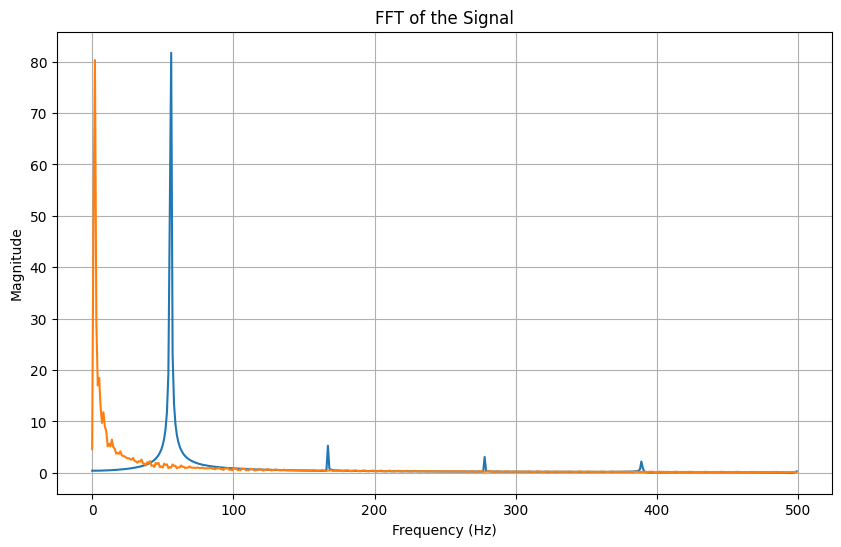

In [17]:
# Perform FFT
wave_eq_fft_result = np.fft.fft(wave_eq_displacements)
wave_eq_fft_magnitude = np.abs(wave_eq_fft_result)[:len(wave_eq_fft_result)//2]  # Take only the positive frequencies

# Plot
plt.figure(figsize=(10, 6))
plt.plot(freqs[:500], fft_magnitude[:500])
plt.plot(freqs[:500], wave_eq_fft_magnitude[:500])
plt.title('FFT of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)


In [18]:
import sounddevice as sd

def normalize_audio(audio):
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        return audio / (8*max_val)
    else:
        return audio

# Normalize audio
audio_normalized = normalize_audio(wave_eq_displacements)

# Play normalized audio
sd.play(audio_normalized, sr)
sd.wait()


In [15]:
max(displacements)

0.005133946426212788